CNN 모형: flatten layer를 통과하면 인접한 픽셀간의 정보가 손실되어 이미지의 특징을 시각적으로 볼 수 없는 단점

 - Class Activation Map(CAM) : 이미지의 특징을 시각화
 - Global Average Pooling(GAP)방식 적용, 각 채널의 평균값으로 pooling

    - max-pooling : 특징빠르게 찾을 때 유리, outlier에 취약
    - average-pooling : outlier에 취약한 점 보완, 과적합 방지

    - global max_pooling : 특징을 빠르게 뽑아낼 수 있음
    - global average_pooling 

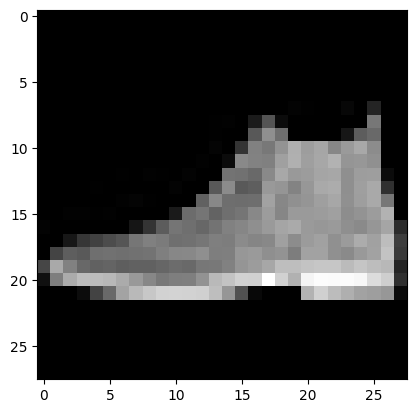

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np

(x_tr, y_tr), (x_ts, y_ts) = tf.keras.datasets.fashion_mnist.load_data()

x_tr, x_ts = x_tr/255.0, x_ts/255.0
plt.imshow(x_ts[0], cmap='gray')
plt.show()

y_tr, y_ts = tf.keras.utils.to_categorical(y_tr), tf.keras.utils.to_categorical(y_ts)

In [2]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((28,28,1), input_shape=(28,28)),
    tf.keras.layers.Conv2D(32, kernel_size=(3,3), padding="SAME", activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding="SAME", activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding="SAME", activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         7

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
model.fit(x_tr, y_tr, batch_size=64, epochs=5, validation_data = (x_ts, y_ts))

Epoch 1/5
938/938 [==============================] - 12s 9ms/step - loss: 0.6863 - accuracy: 0.7519 - val_loss: 0.4918 - val_accuracy: 0.8234
Epoch 2/5
938/938 [==============================] - 8s 8ms/step - loss: 0.4364 - accuracy: 0.8432 - val_loss: 0.4357 - val_accuracy: 0.8454
Epoch 3/5
938/938 [==============================] - 8s 8ms/step - loss: 0.3716 - accuracy: 0.8658 - val_loss: 0.4076 - val_accuracy: 0.8520
Epoch 4/5
938/938 [==============================] - 8s 8ms/step - loss: 0.3338 - accuracy: 0.8794 - val_loss: 0.3705 - val_accuracy: 0.8639
Epoch 5/5
938/938 [==============================] - 8s 8ms/step - loss: 0.3091 - accuracy: 0.8880 - val_loss: 0.3167 - val_accuracy: 0.8875


In [5]:
list(range(len(model.layers) -1, -1, -1))

[8, 7, 6, 5, 4, 3, 2, 1, 0]

In [15]:
def get_cam_image(model_, x, img_size=(28,28), layer_idx = None):
    if layer_idx is None:
        for layer_idx in range(len(model.layers)-1, -1, -1):
            if type(model.layers[layer_idx]) == tf.keras.layers.Conv2D:
                break
    cam_model_ = tf.keras.models.Model(model_.inputs, [model_.layers[layer_idx].output, model_.output])
    conv_out, model_out = cam_model_(x)
    cam_images_ = np.zeros((x.shape[0], img_size[0], img_size[1]))
    for i, outs in enumerate(zip(conv_out, model_out)):
        c_out, m_out = outs
        predict_idx = np.argmax(m_out)
        chosen_weight = model_.layers[-1].weights[0][:, predict_idx]
        cam_img_ = np.zeros(c_out.shape[0:2])
        for j in range(c_out.shape[2]):
            cam_img_ += c_out[:,:,j] * chosen_weight[j]
        cam_images_[i] = cv2.resize(cam_img_.numpy(), img_size)
    return cam_images_
    

In [11]:
test_index = np.arange(10)
test_index

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

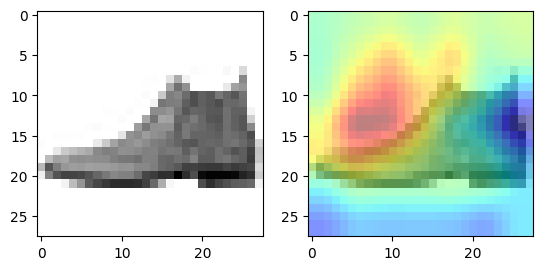

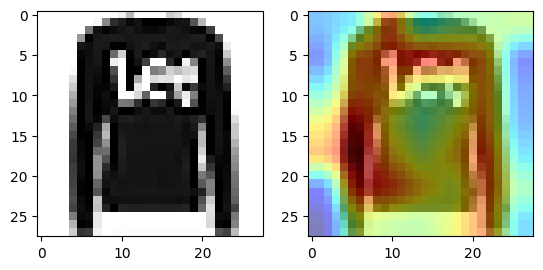

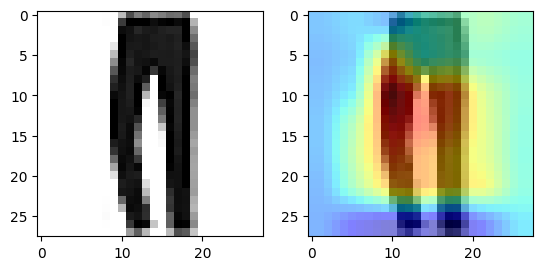

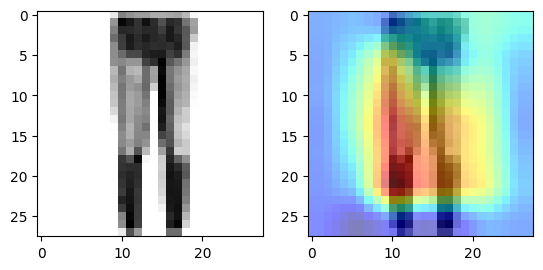

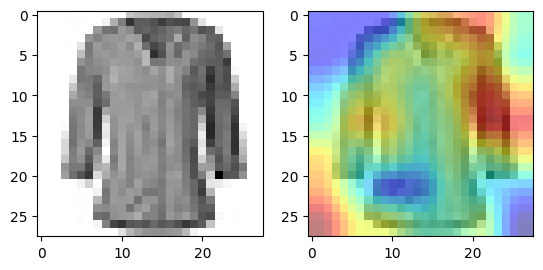

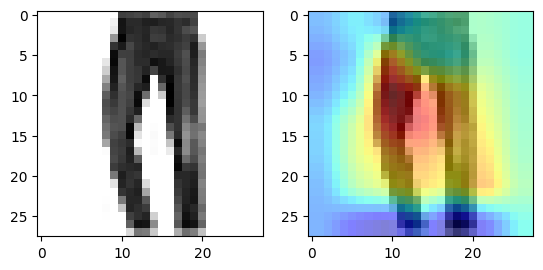

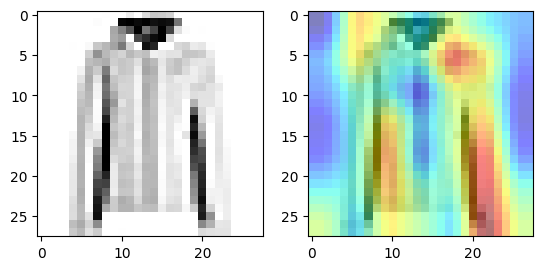

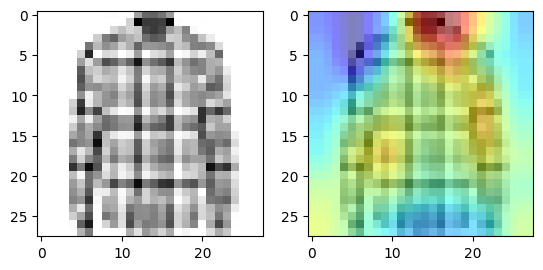

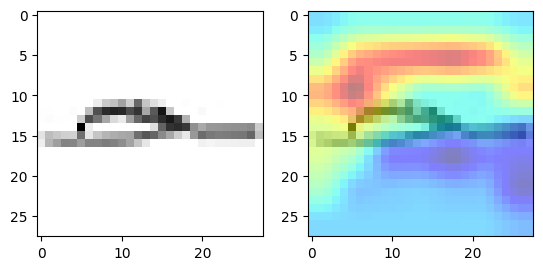

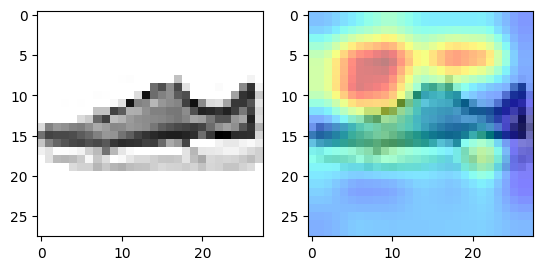

In [16]:
cam_img = get_cam_image(model, x_ts[test_index], img_size=(28,28))
for i, idx in enumerate(test_index):
    plt.subplot(1,2,1)
    plt.imshow(1-x_ts[idx], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(1-x_ts[idx], cmap='gray')
    plt.imshow(cam_img[i], cmap='jet', alpha=0.5)   # overlap
    plt.show()